In [1]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# models, feature extraction, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import random

# imbalance learn
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler, BorderlineSMOTE

# pipeline
from sklearn.pipeline import make_pipeline

# data preprocessing
import contractions
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# string
import re
import string

# warning
import warnings
warnings.filterwarnings('ignore')

# set stopwords
stopwords = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def fix_contractions(text):
    fix = text
    try:
        fix = contractions.fix(text)
    except:
        pass
    return fix

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)
    # return re.sub(r"https?://\S+|www\.\S+", "", text)

def rm_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' '/, text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    fix_contr = fix_contractions(text)
    no_link = rm_link(fix_contr)
    no_punct = rm_punct2(no_link)
    # no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_punct)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [3]:
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def postag(text):
    # not implemented yet
    return

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

## Scratch Implementation

In [4]:
train = pd.read_csv('../data/raw/jigsaw-multilingual/jigsaw-toxic-comment-train.csv')

def is_toxic(row):    
    return 1 if row.sum() > 1 else -1 if row.sum() < 0 else 0

train['is_toxic'] = train.iloc[:, 2:].apply(is_toxic, axis=1)
train['is_toxic'].value_counts()

0    209283
1     14266
Name: is_toxic, dtype: int64

In [5]:
train_norm = train[train['is_toxic'] == 0]
comment_norm = train_norm.comment_text.tolist()

train_tox = train[train['is_toxic'] == 1]
comment_tox = train_tox.comment_text.tolist()

In [6]:
sent_norm_comments = []
sent_tox_comments = []

for cmnt in comment_norm:
    sentences = sent_tokenize(cmnt)
    sent_norm_comments.extend(sentences)
    # sent_comments.append(cmnt)

for cmnt in comment_tox:
    sentences = sent_tokenize(cmnt)
    sent_tox_comments.extend(sentences)

In [13]:
for norm in sent_norm_comments:    
    if '0bama' in norm:
        print(norm)
        break

In [14]:
for tox in sent_tox_comments:
    if '0bama' in tox:
        print(tox)
        break

In [15]:
token_norm = list(map(lambda x: len(x.split()), sent_norm_comments))
token_tox = list(map(lambda x: len(x.split()), sent_tox_comments))

1
1411
15.65461208547814


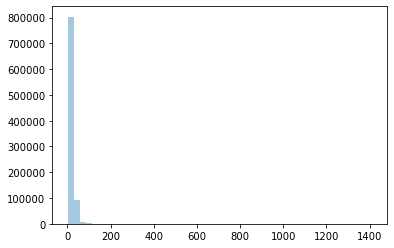

In [16]:
print(min(token_norm))
print(max(token_norm))
print(sum(token_norm) / len(token_norm))

sns.distplot(token_norm, kde=False)
plt.show()

1
2321
11.477516059957173


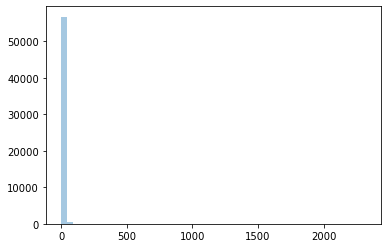

In [17]:
print(min(token_tox))
print(max(token_tox))
print(sum(token_tox) / len(token_tox))

sns.distplot(token_tox, kde=False)
plt.show()

In [36]:
np.quantile(token_tox, .45)

6.0

In [18]:
for t in sent_tox_comments[:10]:
    print(t)

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
You are gay or antisemmitian?
Archangel WHite Tiger

Meow!
Greetingshhh!
Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!
2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!
3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page!
I don't wish to talk to you anymore!
Beware of the Dark Side!
FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!


In [19]:
sent_norm_proc = []
sent_tox_proc = []

for sent in sent_norm_comments:
    clean = clean_pipeline(sent)
    proc = preprocess_pipeline(clean)
    
    sent_norm_proc.append(proc)

for sent in sent_tox_comments:
    clean = clean_pipeline(sent)
    proc = preprocess_pipeline(clean)

    sent_tox_proc.append(proc)

In [22]:
len(sent_norm_proc), len(sent_tox_proc), len(sent_norm_proc+sent_tox_proc)

(908396, 57441, 965837)

In [21]:
# index_norm = np.random.choice(list(range(len(sent_norm_proc))), size=len(sent_tox_proc))
sent_norm_proc_balance = random.sample(sent_norm_proc, len(sent_tox_proc))
len(sent_norm_proc_balance), len(sent_tox_proc)

(57441, 57441)

In [23]:
X_train = sent_norm_proc + sent_tox_proc
y_train = [0] * len(sent_norm_proc) + [1] * len(sent_tox_proc)

In [37]:
cv = CountVectorizer(min_df=6)
X_train_vec = cv.fit_transform(X_train)

In [39]:
sampler = SMOTE(random_state=42, sampling_strategy=.5)
X_resample, y_resample = sampler.fit_resample(X_train_vec, y_train)

In [36]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_vec, y_train)
## if using sampling meth
# 
# 
# 
# od
# lr.fit(X_resample, y_resample)

LogisticRegression(max_iter=1000, random_state=42)

In [37]:
lr.coef_.shape, X_resample.shape

NameError: name 'X_resample' is not defined

In [38]:
woc = np.sum(X_train_vec, axis=0)
weight = lr.coef_

df_weights = pd.DataFrame(np.hstack((weight.T, woc.T)), index=cv.get_feature_names(), columns=['weight', 'occurence'])

toxic_words = df_weights[df_weights['weight'] >= 0.2]
toxic_words.sort_values('weight', ascending=False)

,weight,occurence
oxymoron83,6.388438,176.0
bunksteve,6.337069,278.0
derka,5.599605,141.0
motherfucker,5.060153,619.0
fuck,4.676083,16619.0
...,...,...
gov,0.200298,162.0
yelp,0.200179,6.0
junker,0.200159,5.0
thwart,0.200015,22.0


In [51]:
'0bama' in cv.get_feature_names()

False

In [49]:
df_weights[df_weights.index.str.lower() == '0bama']

,weight,occurence


In [39]:
toxic_words.reset_index(inplace=True)
toxic_words.rename(columns={'index': 'token'}, inplace=True)

In [40]:
toxic_words.to_csv('../data/processed/toxvocab_jigsaw_keep_number.csv', index=False)

## Dataset from Paper

In [41]:
train_norm = open('../data/raw/jigsaw-multilingual/train_normal.txt').readlines()
train_tox = open('../data/raw/jigsaw-multilingual/train_toxic.txt').readlines()

In [42]:
len(train_norm), len(train_tox), len(train_norm + train_tox)

(135390, 135390, 270780)

In [108]:
X_train = train_tox + train_norm
y_train = [1] * len(train_tox) + [0] * len(train_norm)

In [109]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train)

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [110]:
woc = np.sum(X_train_vec, axis=0)
weight = lr.coef_

df_weights = pd.DataFrame(np.hstack((weight.T, woc.T)), index=cv.get_feature_names(), columns=['weight', 'occurence'])

toxic_words = df_weights[df_weights['weight'] >= 0.2]
toxic_words.sort_values('weight', ascending=False)

,weight,occurence
stupid,8.982072,12285.0
idiots,8.937098,3156.0
idiot,8.849322,4518.0
idiotic,8.314623,1175.0
stupidity,8.268952,2629.0
...,...,...
pisshead,0.200051,1.0
cockup,0.200051,1.0
franco,0.200031,5.0
manis,0.200025,2.0


In [111]:
toxic_words.reset_index(inplace=True)
toxic_words.rename(columns={'index': 'token'}, inplace=True)

In [112]:
toxic_words.to_csv('../data/processed/toxvocab_reproduce.csv', index=False)

## Output Comparison

In [43]:
vocab_scratch = pd.read_csv('../data/processed/toxvocab_scratch.csv')
vocab_reprod = pd.read_csv('../data/processed/toxvocab_reproduce.csv')
vocab_jigsaw = pd.read_csv('../data/processed/toxvocab_jigsaw_1st_multiling.csv')
vocab_balanced = pd.read_csv('../data/processed/toxvocab_balanced.csv')
vocab_jigsaw_number = pd.read_csv('../data/processed/toxvocab_jigsaw_keep_number.csv')

len(vocab_scratch), len(vocab_reprod), len(vocab_jigsaw), len(vocab_balanced), len(vocab_jigsaw_number)

(10110, 11616, 13002, 9675, 13450)

In [21]:
# vocab reproduce that is not exist in vocab scratch
not_in_scratch = vocab_reprod[~vocab_reprod['token'].isin(vocab_scratch['token'].tolist())]
not_in_scratch.sort_values(by=['weight'], ascending=False)

,token,weight,occurence
5460,jerks,6.264545,320.0
7439,parasites,5.805062,260.0
5066,imbeciles,5.782384,148.0
6104,lunatics,5.674987,237.0
9316,silly,5.547435,1519.0
...,...,...,...
4431,gupthas,0.200178,1.0
6247,margret,0.200129,1.0
3889,franco,0.200031,5.0
6223,manis,0.200025,2.0


In [22]:
not_in_reprod = vocab_scratch[~vocab_scratch['token'].isin(vocab_reprod['token'].tolist())]
not_in_reprod.sort_values(by=['weight'], ascending=False)

,token,weight,occurence
1244,bunksteve,6.321520,278.0
8674,supertrll,3.793663,152.0
4887,jschnur,3.569991,15.0
1523,chocobos,3.478551,120.0
7694,rvv,3.224125,105.0
...,...,...,...
229,alleges,0.200462,18.0
7972,sharpen,0.200250,6.0
2066,curl,0.200235,12.0
9875,wizz,0.200187,3.0


In [23]:
not_in_jigsaw = vocab_reprod[~vocab_reprod['token'].isin(vocab_jigsaw['token'].tolist())]
not_in_jigsaw

,token,weight,occurence
0,0bama,0.372088,10.0
1,0bamas,0.225272,1.0
2,10ins,0.377675,1.0
3,11year,0.480528,2.0
4,12yearold,0.631296,3.0
...,...,...,...
11611,zt,0.266480,1.0
11612,zuptas,0.368810,3.0
11613,zuptoid,0.555190,8.0
11614,zusman,0.470061,1.0


In [24]:
vocab_jigsaw[~vocab_jigsaw['token'].isin(vocab_scratch['token'].tolist())]

,token,weight,occurence
1,aahh,0.681454,10.0
3,aall,0.444803,4.0
5,aannaall,0.496316,1.0
7,aargh,0.444882,5.0
9,aarrgg,0.785188,1.0
...,...,...,...
12991,zora,0.345131,48.0
12992,zscarpia,0.500011,4.0
12996,zulkifli,0.447637,1.0
12999,zzupupzzuzuz,0.600403,1.0


In [25]:
vocab_reprod[~vocab_reprod['token'].isin(vocab_balanced['token'].tolist())]

,token,weight,occurence
0,0bama,0.372088,10.0
1,0bamas,0.225272,1.0
2,10ins,0.377675,1.0
3,11year,0.480528,2.0
4,12yearold,0.631296,3.0
...,...,...,...
11611,zt,0.266480,1.0
11612,zuptas,0.368810,3.0
11613,zuptoid,0.555190,8.0
11614,zusman,0.470061,1.0


In [44]:
not_in_jigsaw_number = vocab_reprod[~vocab_reprod['token'].isin(vocab_jigsaw_number['token'].tolist())]
not_in_jigsaw_number

,token,weight,occurence
0,0bama,0.372088,10.0
1,0bamas,0.225272,1.0
2,10ins,0.377675,1.0
3,11year,0.480528,2.0
4,12yearold,0.631296,3.0
...,...,...,...
11611,zt,0.266480,1.0
11612,zuptas,0.368810,3.0
11613,zuptoid,0.555190,8.0
11614,zusman,0.470061,1.0
